In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.metrics import accuracy_score
import math
import numpy as np
from numpy.linalg import qr, norm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.cm as cm
import urllib

In [2]:
X_train_input = pd.read_csv("20news-bydate/matlab/train.data", delimiter=" ",names = ["docIdx", "wordIdx", "freq"],)
y_train_input = pd.read_csv("20news-bydate/matlab/train.label", names=["labels"])
y_train_input['docIdx'] = y_train_input.index + 1
X_test_input = pd.read_csv("20news-bydate/matlab/test.data", delimiter=" ", names = ["docIdx", "wordIdx", "freq"],)
y_test_input = pd.read_csv("20news-bydate/matlab/test.label", names=["labels"])
y_test_input['docIdx'] = y_test_input.index + 1

word_cnt = X_train_input[["wordIdx", "freq"]].groupby(["wordIdx"], as_index=False).sum().sort_values(by='freq', ascending=False)
word_cnt_filtered = word_cnt[word_cnt['freq']>1000].reset_index()

def preprocessing(X_df, y_df):
    X_df_filtered = X_df.loc[X_df["wordIdx"].isin(word_cnt_filtered.wordIdx)].reset_index(drop=True)
    
    # combine X_* and y_*
    combined_data = X_df_filtered.merge(y_df, on="docIdx", how="inner")
    X = combined_data
    y = combined_data['labels']
    return X,y

X_train, y_train = preprocessing(X_train_input, y_train_input)
X_test, y_test = preprocessing(X_test_input, y_test_input)

def tfidf_matrix(data, words):
    total_doc = len(data)#.groupby(["wordIdx"]))
    idf = []
    for index, group in data.groupby(["wordIdx"], as_index = False).agg(list).iterrows():
        idf.append( math.log ( total_doc / len(group.docIdx) ) )
    X = []
    y = []
    tfidf = []
    for index, group in data.groupby(["docIdx"], as_index = False).agg(list).iterrows():
        x = [0 for i in range(len(words))]
        y.append(group.labels[0])
        for ind in range(len(words)):
            # print(words[ind])
            if words.wordIdx[ind] in group.wordIdx:
                x[ind] = group.freq[group.wordIdx.index(words.wordIdx[ind])]
            # if word[1].wordIdx in group.wordIdx:
            #     x[words.index(word)] = group.freq[group.wordIdx.index(word[1].wordIdx)] / sum(group.freq)
        X.append(x)

    for i in range(len(X)):
        x = []
        total_words_doc = sum(X[i])
        for j in range(len(X[0])):
            x.append(X[i][j] / total_words_doc * idf[j])
        tfidf.append(x)

    # print(y[0])
    return np.array(tfidf), np.array(y)

X_train, y_train = tfidf_matrix(X_train, word_cnt_filtered)
y_train = y_train - 1
X_test, y_test = tfidf_matrix(X_test, word_cnt_filtered)
y_test = y_test - 1

In [4]:
n,m = X_train.shape
k = len(set(y_train)) # number of labels
def stochastic_proximal_gradient_descent_algo(num_iters, lambda_, step_size_type="diminishing"):
    theta = np.zeros((m,k))
    ret_accuracy = []
    for t in range(1,num_iters):
        if step_size_type == "diminishing":
            step_size = 1.0/t
        else:
            step_size = 0.01
        i = np.random.randint(n)
        x_i = X_train[i,:]
        y_i = y_train[i]

        conditional_y = np.ones(k, dtype=int)
        conditional_y[y_i] = 0

        scores = x_i @ theta
        margins = scores - scores[y_i] + 1
        margins[y_i] = -np.inf
        

        y_i_hat = np.argmax( margins )#x_i @ theta - x_i @ theta[:,y_i] + conditional_y)
        theta_temp = theta

        if y_i != y_i_hat:
            theta_temp[:, y_i] = theta[:, y_i] + step_size * x_i
            theta_temp[:, y_i_hat] = theta[:, y_i_hat] - step_size * x_i

        for j in range(m):
            v = np.linalg.norm(theta_temp[j])
            if v <= step_size * lambda_ :
                theta_temp[j] = 0
            else:
                theta_temp[j] = (1 - ((step_size * lambda_) / v) ) * theta_temp[j]

        theta = theta_temp

        if t%1000 == 0:
            # print(t, end=" ")
            ret_accuracy.append(get_prediction_accuracy(theta))

    # print()
    return ret_accuracy, theta
        

In [6]:
def get_prediction_accuracy(theta):
    y_pred = np.argmax(X_test @ theta, axis = 1)
    return accuracy_score(y_test, y_pred)

In [7]:
lambdas = [10, 1, 0.1, 0.01]
results = {}
thetas = {}
for i in lambdas:
    print("Lambda =", i)
    results[i], thetas[i] = stochastic_proximal_gradient_descent_algo(1000001,i)

Lambda = 10
Lambda = 1
Lambda = 0.1
Lambda = 0.01


Text(0.5, 1.0, 'Proximal Subgradient Algorithm')

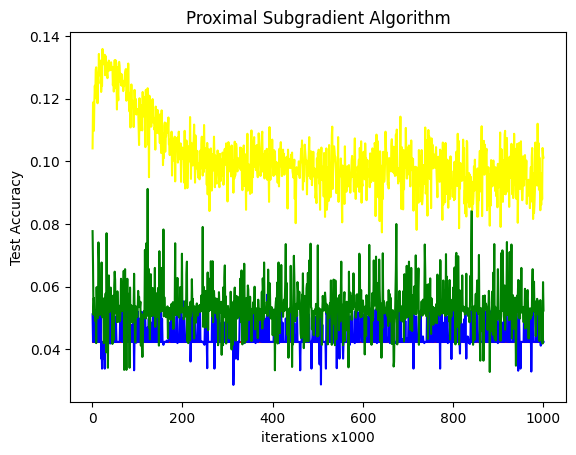

In [16]:
iters = [i for i in range(1,1001)]
colors = {10: "red", 1:"blue", 0.1: "green", 0.01:"yellow"}
for res in results:
    plt.plot(iters,results[res], color=colors[res])

plt.xlabel("iterations x1000")
plt.ylabel("Test Accuracy")
plt.title("Proximal Subgradient Algorithm")